In [82]:
import torch
import torch.nn as nn
from utils.model import GCN
from utils.h36motion3d import H36motion3D
from torch.utils.data import DataLoader
import utils.model as nnmodel
from utils.opt import Options
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_n = 10
output_n = 25

train_dataset = H36motion3D(path_to_data='./h3.6m/dataset', actions='all', input_n=input_n, output_n=output_n,
                          split=0, sample_rate=2, subset=True)

Reading subject 1, action walking, subaction 1
Reading subject 1, action walking, subaction 2


In [4]:
# for k, v in mod.state_dict().items():
#     print(k, v.shape)
# print(sum([p.numel() for p in mod.parameters()]))

In [5]:
opt = Options()
opt._initial()

class MyOpt:
    def __init__(self):
        self.output_n = opt.parser.get_default('output_n')
        self.input_n = opt.parser.get_default('input_n')
        self.dct_n = opt.parser.get_default('dct_n')
        self.linear_size = opt.parser.get_default('linear_size')
        self.num_stage = opt.parser.get_default('num_stage')
        self.dropout = opt.parser.get_default('dropout') 
        self.data_dir = opt.parser.get_default('data_dir') 
        self.sample_rate = opt.parser.get_default('sample_rate')
        self.test_batch = opt.parser.get_default('test_batch')
        
        self.job = opt.parser.get_default('job')
        self.test_batch = opt.parser.get_default('test_batch')
        self.test_batch = opt.parser.get_default('test_batch')
        self.test_batch = opt.parser.get_default('test_batch')
        
        
opt = MyOpt()
dct_n = opt.dct_n
input_n = opt.input_n
output_n = opt.output_n
sample_rate = opt.sample_rate


model = nnmodel.InceptionGCN(opt.linear_size, opt.dropout, num_stage=opt.num_stage, node_n=66, opt=opt)
model.load_state_dict(torch.load('checkpoint/test/ckpt_main_3d_3D_in10_out25_dct_n_30_best.pth.tar', map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

In [7]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8)

In [83]:
some_batch = next(iter(train_loader))[0][0][None, :]

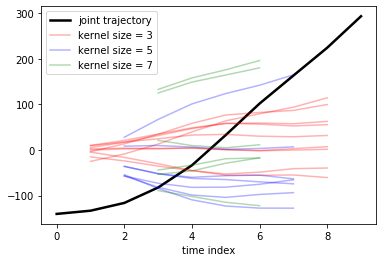

In [104]:
joint_nb = np.random.randint(66)
out = model.time_inception_mod(some_batch[:, :, :opt.input_n])[0, joint_nb].detach().numpy()
plt.plot(np.arange(opt.input_n), out[:opt.input_n], label='joint trajectory', c='black', linewidth=2.5)
out = out[opt.input_n:]
colors = {3:'red', 5:'blue', 7:'green'}

for conv in model.time_inception_mod.convolutions:
    for p in conv.parameters():
        if len(p.shape) == 3:
            for channel in range(p.shape[0]):
                length = opt.input_n-p.shape[2]+1
                seq = out[:length]
                out = out[length:]
                if p.shape[2] != 2:
                    plt.plot(np.arange(length)+(p.shape[2]-1)//2, seq, alpha=0.3, color=colors[p.shape[2]], 
                             label='kernel size = {}'.format(p.shape[2]) if channel == 0 else "")
                    
plt.xlabel('time index')
plt.legend()
plt.show()